In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import newaxis
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    LSTM,
    BatchNormalization,
    LayerNormalization,
    Activation,
    Dropout,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations

In [116]:
WINDOW_SIZE = 100
TRAIN_RATE = 0.7

L2_NORM = 0.01
DROPOUT_RATE = 0.05

LEARNING_RATE = 0.005
BETA_1 = 0.9
BETA_2 = 0.999

TRUNCATION_UNIT = 64

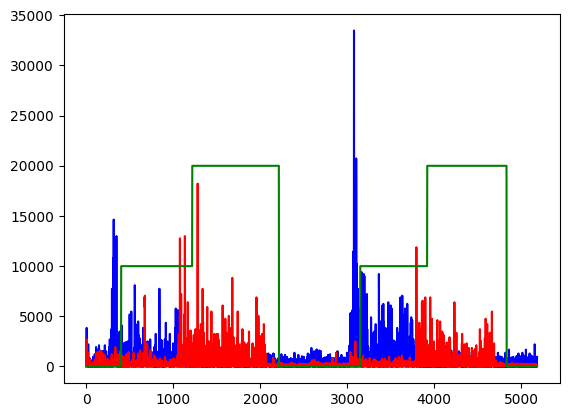

<class 'numpy.ndarray'> (5184, 3)


In [117]:
dataset = pd.read_csv(
    "/home/Hand-Gesture-Recognition-Using-ML-with-EMG-Sensors/2_EMG_Sensors_Discrete.csv"
)
plt.plot(dataset.iloc[:, 0], "b")
plt.plot(dataset.iloc[:, 1], "r")
dataset_y = list(i * 10000 for i in dataset.iloc[:, 2])
plt.plot(dataset_y, "g")
plt.show()

dataset = dataset.values.reshape(dataset.shape)
print(type(dataset), dataset.shape)

In [118]:
X, y = list(), list()
for i, _ in enumerate(dataset):
    if i + WINDOW_SIZE > len(dataset) - 1:
        break
    seq_X = dataset[i : i + WINDOW_SIZE, :-1]
    seq_y = dataset[i + WINDOW_SIZE, -1]
    # one-hot encoding
    if seq_y == 0:
        seq_y = (1, 0, 0)
    elif seq_y == 1:
        seq_y = (0, 1, 0)
    elif seq_y == 2:
        seq_y = (0, 0, 1)

    X.append(seq_X)
    y.append(seq_y)

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(5084, 100, 2) (5084, 3)


In [119]:
dataset_size = len(X)
train_size = int(dataset_size * TRAIN_RATE)

X_train, y_train = X[:train_size, :], y[:train_size, :]
X_val, y_val = X[train_size:, :], y[train_size:, :]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(3558, 100, 2) (3558, 3) (1526, 100, 2) (1526, 3)


In [120]:
model = Sequential()
# model.add(
#     Conv2D(
#         32,
#         kernel_size=(4, 2),
#         padding="same",
#         input_shape=(1000, 8, 1),
#         kernel_regularizer=regularizers.L2(l2=L2_NORM),
#     )
# )
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Dropout(rate=DROPOUT_RATE))
# model.add(MaxPooling2D(pool_size=(5, 2)))  # output_shape = (200, 4, 1)

model.add(
    LSTM(
        50,
        input_shape=(X.shape[1], X.shape[2]),
        kernel_regularizer=regularizers.L1L2(0, L2_NORM),
    )
)
model.add(LayerNormalization())
model.add(Activation(activations.tanh))
model.add(Dropout(rate=DROPOUT_RATE))
model.add(Dense(3, activation="softmax"))

optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 50)                10600     
                                                                 
 layer_normalization_12 (La  (None, 50)                100       
 yerNormalization)                                               
                                                                 
 activation_11 (Activation)  (None, 50)                0         
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 153       
                                                                 
Total params: 10853 (42.39 KB)
Trainable params: 10853 (42.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [121]:
history = model.fit(
    X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=1
)

Epoch 1/50
112/112 [==============================] - 3s 14ms/step - loss: 0.7196 - accuracy: 0.6981 - val_loss: 0.9957 - val_accuracy: 0.6737
Epoch 2/50
112/112 [==============================] - 1s 10ms/step - loss: 0.1585 - accuracy: 0.9629 - val_loss: 1.7465 - val_accuracy: 0.5518
Epoch 3/50
112/112 [==============================] - 1s 10ms/step - loss: 0.1056 - accuracy: 0.9744 - val_loss: 1.0280 - val_accuracy: 0.7202
Epoch 4/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0714 - accuracy: 0.9829 - val_loss: 1.3396 - val_accuracy: 0.6710
Epoch 5/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0522 - accuracy: 0.9879 - val_loss: 1.0581 - val_accuracy: 0.7333
Epoch 6/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0700 - accuracy: 0.9820 - val_loss: 1.0127 - val_accuracy: 0.7353
Epoch 7/50
112/112 [==============================] - 1s 10ms/step - loss: 0.0624 - accuracy: 0.9854 - val_loss: 1.4949 - val_accuracy: 0.6140

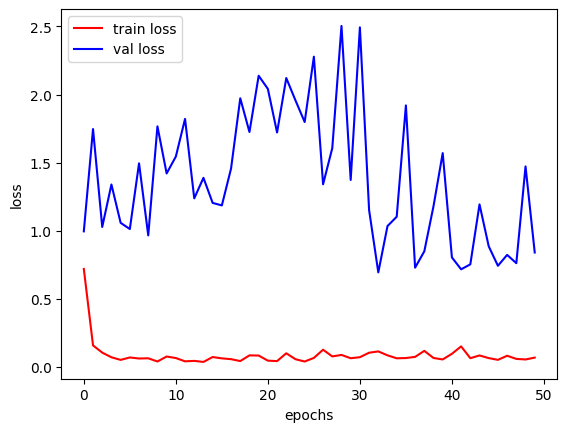

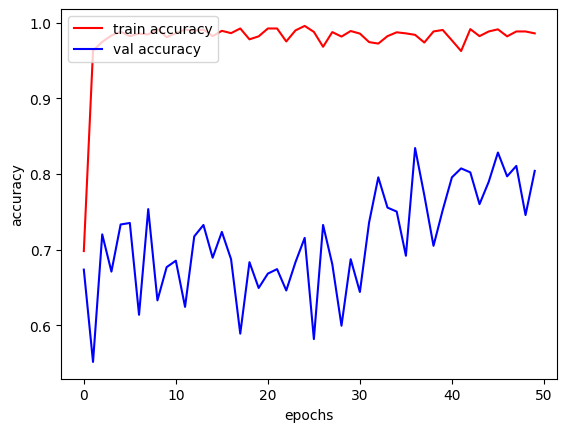

In [122]:
history.history.keys()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history["loss"], "r")
plt.plot(history.history["val_loss"], "b")
plt.legend(["train loss", "val loss"], loc="upper left")
plt.show()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(history.history["accuracy"], "r")
plt.plot(history.history["val_accuracy"], "b")
plt.legend(["train accuracy", "val accuracy"], loc="upper left")

48/48 [==============================] - 0s 6ms/step


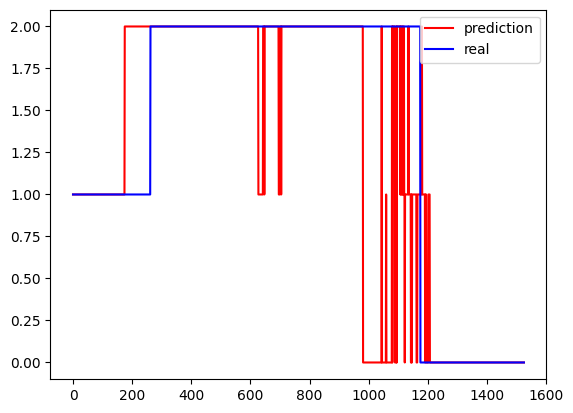

In [124]:
X_pred = model.predict(X_val)
a, b = list(), list()
for i, item in enumerate(X_pred):
    a.append(np.argmax(item))
    b.append(np.argmax(y_val[i]))

plt.plot(a, "r")
plt.plot(b, "b")
plt.legend(["prediction", "real"], loc="upper right")